### Load modules

In [1]:
%load_ext autoreload
%matplotlib inline

In [4]:
%autoreload 2

from IPython import display
from utils import Logger 

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import trimesh
import trimesh.voxel.creation
import rtree

In [5]:
from torch.utils.data import Dataset

In [6]:
import scipy.ndimage as ndimage

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

In [8]:
from os import listdir
from os.path import join

In [108]:
torch.set_printoptions(profile="full")

### Load .obj files

In [63]:
data_folder='./inputs'

In [86]:
objects = []
for file in listdir(data_folder):
    if file.endswith(".stl"):
        m = trimesh.load_mesh(join(data_folder,file))
        #convert to voxels
        m_vox = trimesh.voxel.creation.voxelize(m,0.2)        
        objects.append(m_vox)
    

In [87]:
m_vox.show()

##### Pad tensors

In [70]:
# Define size of the space (pix)
scene_size = 32

In [88]:
# convert to tensors
vox_meshes = []
for m in objects:
    object_matrix = torch.from_numpy(m.matrix) # torch.ones(m.matrix.shape)
    scene_matrix = torch.zeros((scene_size,scene_size,scene_size))
    
    # center the matrices in the scene
    low = (int)(scene_matrix.size(0)//2) - (int)(object_matrix.size(0)//2)
    up = low + object_matrix.size(0)
    
    low1 = (int)(scene_matrix.size(1)//2) - (int)(object_matrix.size(1)//2)
    up1 = low1 + object_matrix.size(1)
    
    low2 = (int)(scene_matrix.size(2)//2) - (int)(object_matrix.size(2)//2)
    up2 = low2 + object_matrix.size(2)
    
    print(object_matrix.shape)
    scene_matrix[low:up,low1:up1,low2:up2] = object_matrix
    vox_meshes.append((scene_matrix))
    
#     matrix = torch.from_numpy(m.matrix) 
#     target = torch.zeros(scene_size,scene_size,scene_size)
#     source = torch.ones(matrix.shape)
#     target[:source.size(0), :source.size(1), :source.size(2)] = matrix
#     vox_meshes.append(target.reshape([1,scene_size,scene_size,scene_size]))

torch.Size([23, 23, 11])
torch.Size([13, 11, 7])
torch.Size([23, 23, 11])
torch.Size([15, 17, 7])
torch.Size([23, 23, 13])
torch.Size([14, 13, 5])
torch.Size([31, 31, 13])
torch.Size([23, 23, 11])
torch.Size([15, 13, 7])


In [109]:
vox_meshes[0]

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.

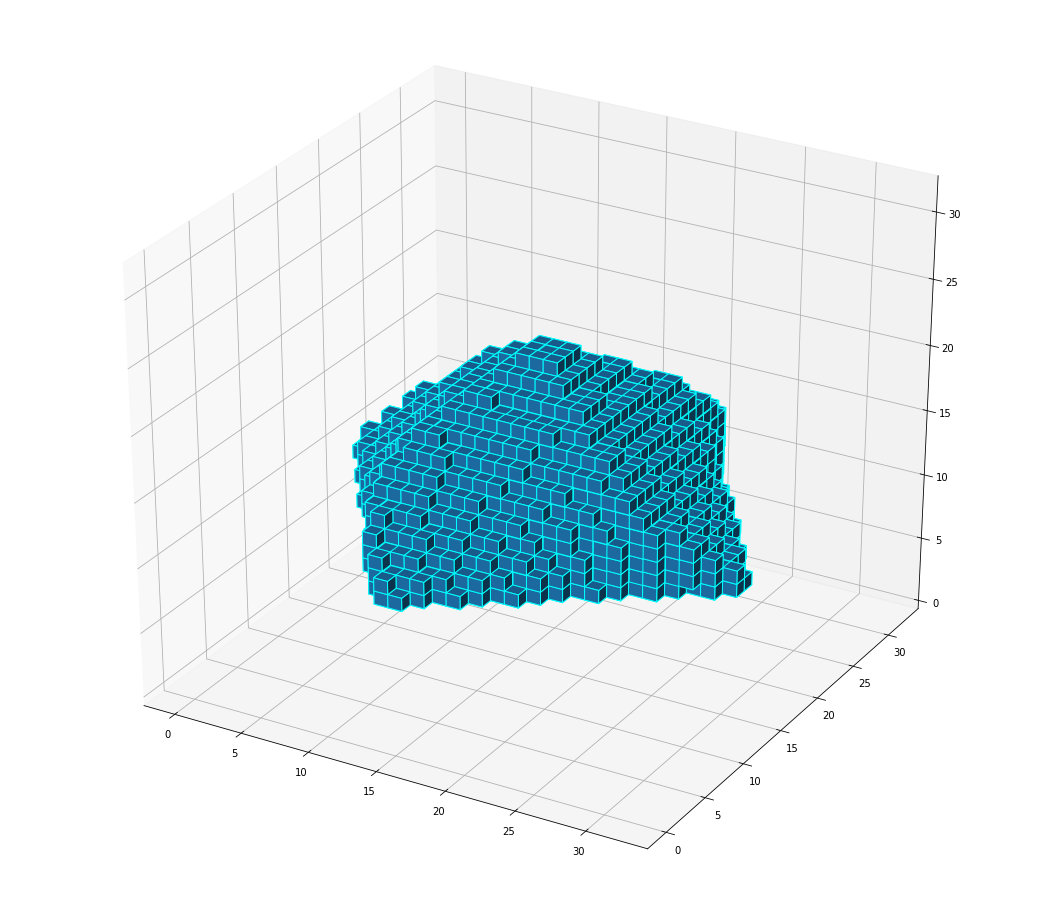

In [139]:
#show a sample

colors = np.empty(vox_meshes[6].shape, dtype=object)
fig = plt.figure()
fig.set_size_inches(18.5, 16.5)
ax = fig.gca(projection='3d')
ax.voxels(vox_meshes[6], edgecolor='cyan')
plt.show()

In [90]:
#dataset class
class object_dataset(Dataset):
    def __init__(self):
        self.samples = vox_meshes

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [91]:
input_data = object_dataset() #load the data

### My Networks

In [92]:
class DiscriminatorNet(torch.nn.Module):
    
    #3 hidden-layer discriminative nn
    
    def __init__(self, scene_size = 32):
        super(DiscriminatorNet, self).__init__()
        self.n_features = scene_size * scene_size * scene_size
        self.n_out=1
        self.scene_size = scene_size
        
        pad = (1,1,1)
        
        self.conv1 = nn.Sequential(
            torch.nn.Conv3d(1, self.scene_size, kernel_size=4, stride=2, bias=False, padding= pad),
            torch.nn.BatchNorm3d(self.scene_size),
            torch.nn.LeakyReLU(0.2)
        )
        
        self.conv2 = nn.Sequential(
        torch.nn.Conv3d(self.scene_size,self.scene_size*2,kernel_size=4,stride=2,bias=False,padding=pad),
        torch.nn.BatchNorm3d(self.scene_size*2),
        torch.nn.LeakyReLU(0.2)
        )
        
        self.conv3 = nn.Sequential(
        torch.nn.Conv3d(self.scene_size*2, self.scene_size*4,kernel_size=4,stride=2, bias=False, padding= pad),
        torch.nn.BatchNorm3d(self.scene_size*4),
        torch.nn.LeakyReLU(0.2)
        )
        
        self.conv4 =  nn.Sequential(
        torch.nn.Conv3d(self.scene_size*4,self.scene_size*8,kernel_size=4, stride=2, bias=False, padding= pad),
        torch.nn.BatchNorm3d(self.scene_size*8),
        torch.nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
        torch.nn.Conv3d(self.scene_size*8,self.n_out,kernel_size=4, stride=2, bias=False, padding= pad),
        torch.nn.Sigmoid()
        )

        
    def forward(self, x):
        x = x.view(-1, 1, self.scene_size, self.scene_size, self.scene_size)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.out(x)
        return x

        


In [93]:
class GeneratorNet(torch.nn.Module):
    
    #3 hidden-layer discriminative nn
    
    def __init__(self, scene_size = 32, n_features = 64):
        super(GeneratorNet, self).__init__()
        self.scene_size = scene_size
        self.n_features = n_features
        self.n_out=1
        
        
        pad = (1,1,1)
        
        self.conv1 = nn.Sequential(
            torch.nn.ConvTranspose3d(self.n_features, self.scene_size * 8, kernel_size=4, stride=2, bias=False, padding= pad),
            torch.nn.BatchNorm3d(self.scene_size*8),
            torch.nn.ReLU()
        )
        
        self.conv2 = nn.Sequential(
        torch.nn.ConvTranspose3d(self.scene_size*8,self.scene_size*4,kernel_size=4,stride=2,bias=False,padding=pad),
        torch.nn.BatchNorm3d(self.scene_size*4),
        torch.nn.ReLU()
        )
        
        self.conv3 = nn.Sequential(
        torch.nn.ConvTranspose3d(self.scene_size*4, self.scene_size*2,kernel_size=4,stride=2, bias=False, padding= pad),
        torch.nn.BatchNorm3d(self.scene_size*2),
        torch.nn.ReLU()
        )
        
        self.conv4 =  nn.Sequential(
        torch.nn.ConvTranspose3d(self.scene_size*2,self.scene_size,kernel_size=4, stride=2, bias=False, padding= pad),
        torch.nn.BatchNorm3d(self.scene_size),
        torch.nn.ReLU()
        )
        
        self.out = nn.Sequential(
        torch.nn.ConvTranspose3d(self.scene_size,self.n_out,kernel_size=4, stride=2, bias=False, padding= pad),
        torch.nn.Sigmoid()
        )

        
    def forward(self, x):
        x = x.view(-1, self.n_features, 1,1,1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.out(x)
        return x

        


#### Create the model

In [94]:
class adversarialModel(object):
    def __init__(self, num_epochs=100, samples=3, batch=3, betas=(0.5,0.5),
                g_lr=0.002, d_lr=0.001, size=64, lat_vec =200,
                data_path='output/models/', transforms=None):
        #define parameters
        self.num_epochs=num_epochs
        self.samples = samples
        self.batch = batch
        self.betas = betas
        self.g_lr = g_lr
        self.d_lr = d_lr
        self.size = size
        self.latent = lat_vec
        self.dataset = 'input_data'
        self.name = 'voxModel'
        
        #define networks
        self.generator = GeneratorNet(scene_size=32,n_features=self.latent)
        self.discriminator = DiscriminatorNet(scene_size = 32)
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=self.d_lr, betas=self.betas)
        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=self.d_lr, betas=self.betas)
        self.loss = nn.BCELoss()
        
        self.generator.cuda()
        self.discriminator.cuda()
        
        #data
        data_set = object_dataset()
        self.data_loader = torch.utils.data.DataLoader(data_set, batch_size=self.batch, shuffle=True, num_workers=0)
        
    def train(self):
        
        for epoch in range(self.num_epochs):
            print('Epoch : ', epoch)
            
            for i,x in enumerate(self.data_loader):
                print('Batch : ', i)
                x = x.cuda()
                
                if(x.size()[0] != self.batch):
                    print('Batch size incompatible')
                    continue
                
                
                z = make_noise(self.batch, self.latent)
                z = z.cuda()
                
                #train discriminator
                prediction_real = self.discriminator(x)
                d_real_loss = self.loss(prediction_real,real_data_target(prediction_real.size(0)))
                
                fake_samples = self.generator(z)
                prediction_fake = self.discriminator(fake_samples )
                d_fake_loss = self.loss(prediction_fake, fake_data_target(self.batch))
                
                d_total_loss = d_real_loss + d_fake_loss
                
                #check if accuracy is below some limit and reset gradient
                d_real_acuracy = torch.ge(prediction_real.squeeze(), 0.5).float()
                d_fake_acuracy = torch.le(prediction_fake.squeeze(), 0.5).float()
                d_total_acuracy = torch.mean(torch.cat((d_real_acuracy,d_fake_acuracy),0))
                
                if d_total_acuracy <= 0.7:
                    self.discriminator.zero_grad()
                    d_total_loss.backward(retain_graph=True)
                    self.d_optimizer.step()
                    
                #regenerate samples and train generator
                z = make_noise(self.batch, self.latent)
                z = z.cuda()
                fake_samples = self.generator(z)
                prediction_fake = self.discriminator(fake_samples)
                g_loss = self.loss(prediction_fake, real_data_target(prediction_fake.size(0)))
                
                #zero all gradients
                self.discriminator.zero_grad()
                self.generator.zero_grad()
                g_loss.backward()
                self.g_optimizer.step()
                
                if epoch%10 == 0 : 
                    print('discriminator loss: ',d_total_loss, '  generator loss: ', g_loss)
                    print('accuracy: ',d_total_acuracy)
                    #display_samples(fake_samples)
                    print(fake_samples.shape)
                
                
                
        

#### Display function

In [95]:
def display_samples(vox_to_display):
    vox_to_display = vox_to_display.cpu().data.squeeze().numpy()
    print(vox_to_display.shape)
    #get the values > number
    voxels = vox_to_display.__ge__(0.5)
    fig = plt.figure(figsize=(32, 16))
    gs = gridspec.GridSpec(2, 4)
    gs.update(wspace=0.05, hspace=0.05)

    #print(voxels)
    for i, sample in enumerate(voxels):
        #print(sample.shape)
        s = sample.nonzero()#.reshape([3,27000])
        
        colors = np.empty(nonzero[0].shape, dtype=object)
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.voxels(s[0], edgecolor='cyan')
        plt.show()

#         #print(s)
#         x,y,z = s
        
#         ax = plt.subplot(gs[i], projection='3d')
#         ax.scatter(x, y, z, zdir='z', c='red')
#         ax.set_xticklabels([])
#         ax.set_yticklabels([])

#     fig = plt.figure()
#     ax = fig.gca(projection='3d')
#     plt.show()


Function to generate sample noise

In [110]:
def make_noise(size,latent):
    noise = torch.Tensor(size,latent)#.normal_(0, 0.33)
    return noise

Real and fake labels

In [111]:
def real_data_target(size):
    
    # Tensor containing ones(real)
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    
    # Tensor containing ones(fake)    
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

### Training

In [112]:
myModel = adversarialModel(num_epochs=1000, samples=3, batch=3, betas=(0.5,0.5),
          g_lr=0.0001, d_lr=0.0001, size=32, lat_vec =100,data_path='output/models/', transforms=None)

In [113]:
myModel.train() #reaaaaally bad results :) 

Epoch :  0
Batch :  0
discriminator loss:  

C:\Users\Alexandra\ANACONDA3\lib\site-packages\torch\nn\modules\loss.py:516: UserWarning: Using a target size (torch.Size([3, 1])) that is different to the input size (torch.Size([3, 1, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


tensor(1.3732, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(2.0834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(0.3333, device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  1
discriminator loss:  tensor(1.0321, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(0.9359, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  2
discriminator loss:  tensor(1.1708, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.8746, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(0.5000, device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Epoch :  1
Batch :  0
Batch :  1
Batch :  2
Epoch :  2
Batch :  0
Batch :  1
Batch :  2
Epoch :  3
Batch :  0
Batch :  1
Batch :  2
Epoch :  4
Batch :  0
Batch :  1
Batch :  2
Epoch :  5
Batch :  0
Batch :  1
Batch :  2
Epoch :  6
Batch :  0
Batch :  1
Batch :  2
Epoch :  7
Batch : 

discriminator loss:  tensor(0.3597, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.8984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  2
discriminator loss:  tensor(0.4478, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.7273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Epoch :  71
Batch :  0
Batch :  1
Batch :  2
Epoch :  72
Batch :  0
Batch :  1
Batch :  2
Epoch :  73
Batch :  0
Batch :  1
Batch :  2
Epoch :  74
Batch :  0
Batch :  1
Batch :  2
Epoch :  75
Batch :  0
Batch :  1
Batch :  2
Epoch :  76
Batch :  0
Batch :  1
Batch :  2
Epoch :  77
Batch :  0
Batch :  1
Batch :  2
Epoch :  78
Batch :  0
Batch :  1
Batch :  2
Epoch :  79
Batch :  0
Batch :  1
Batch :  2
Epoch :  80
Batch :  0
discriminator loss:  tensor(0.4422, device='cuda:0', grad_fn=<AddBackward0>)   generator 

Batch :  1
Batch :  2
Epoch :  142
Batch :  0
Batch :  1
Batch :  2
Epoch :  143
Batch :  0
Batch :  1
Batch :  2
Epoch :  144
Batch :  0
Batch :  1
Batch :  2
Epoch :  145
Batch :  0
Batch :  1
Batch :  2
Epoch :  146
Batch :  0
Batch :  1
Batch :  2
Epoch :  147
Batch :  0
Batch :  1
Batch :  2
Epoch :  148
Batch :  0
Batch :  1
Batch :  2
Epoch :  149
Batch :  0
Batch :  1
Batch :  2
Epoch :  150
Batch :  0
discriminator loss:  tensor(0.5930, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(0.8645, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  1
discriminator loss:  tensor(0.8323, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(0.7671, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  2
discriminator loss:  tensor(0.7453, device='cuda:0', grad_fn=<AddBackward0>)   generator los

Epoch :  212
Batch :  0
Batch :  1
Batch :  2
Epoch :  213
Batch :  0
Batch :  1
Batch :  2
Epoch :  214
Batch :  0
Batch :  1
Batch :  2
Epoch :  215
Batch :  0
Batch :  1
Batch :  2
Epoch :  216
Batch :  0
Batch :  1
Batch :  2
Epoch :  217
Batch :  0
Batch :  1
Batch :  2
Epoch :  218
Batch :  0
Batch :  1
Batch :  2
Epoch :  219
Batch :  0
Batch :  1
Batch :  2
Epoch :  220
Batch :  0
discriminator loss:  tensor(0.6668, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.3991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  1
discriminator loss:  tensor(0.7326, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.3607, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  2
discriminator loss:  tensor(0.4212, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.3232, dev

Batch :  2
Epoch :  283
Batch :  0
Batch :  1
Batch :  2
Epoch :  284
Batch :  0
Batch :  1
Batch :  2
Epoch :  285
Batch :  0
Batch :  1
Batch :  2
Epoch :  286
Batch :  0
Batch :  1
Batch :  2
Epoch :  287
Batch :  0
Batch :  1
Batch :  2
Epoch :  288
Batch :  0
Batch :  1
Batch :  2
Epoch :  289
Batch :  0
Batch :  1
Batch :  2
Epoch :  290
Batch :  0
discriminator loss:  tensor(0.7761, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(0.8193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  1
discriminator loss:  tensor(0.7503, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(2.0604, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(0.5000, device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  2
discriminator loss:  tensor(0.4799, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.8683, device='cuda:0', grad_fn=<BinaryCr

Batch :  2
Epoch :  353
Batch :  0
Batch :  1
Batch :  2
Epoch :  354
Batch :  0
Batch :  1
Batch :  2
Epoch :  355
Batch :  0
Batch :  1
Batch :  2
Epoch :  356
Batch :  0
Batch :  1
Batch :  2
Epoch :  357
Batch :  0
Batch :  1
Batch :  2
Epoch :  358
Batch :  0
Batch :  1
Batch :  2
Epoch :  359
Batch :  0
Batch :  1
Batch :  2
Epoch :  360
Batch :  0
discriminator loss:  tensor(0.6759, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.4537, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(0.8333, device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  1
discriminator loss:  tensor(0.4676, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.3257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  2
discriminator loss:  tensor(0.6060, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.2140, device='cuda:0', grad_fn=<BinaryCr

Epoch :  423
Batch :  0
Batch :  1
Batch :  2
Epoch :  424
Batch :  0
Batch :  1
Batch :  2
Epoch :  425
Batch :  0
Batch :  1
Batch :  2
Epoch :  426
Batch :  0
Batch :  1
Batch :  2
Epoch :  427
Batch :  0
Batch :  1
Batch :  2
Epoch :  428
Batch :  0
Batch :  1
Batch :  2
Epoch :  429
Batch :  0
Batch :  1
Batch :  2
Epoch :  430
Batch :  0
discriminator loss:  tensor(0.6575, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(0.8638, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  1
discriminator loss:  tensor(0.7497, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(0.8602, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  2
discriminator loss:  tensor(0.5979, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(0.8520, device='cuda:0', grad_fn=<BinaryCrossEntropyBackw

Batch :  1
Batch :  2
Epoch :  494
Batch :  0
Batch :  1
Batch :  2
Epoch :  495
Batch :  0
Batch :  1
Batch :  2
Epoch :  496
Batch :  0
Batch :  1
Batch :  2
Epoch :  497
Batch :  0
Batch :  1
Batch :  2
Epoch :  498
Batch :  0
Batch :  1
Batch :  2
Epoch :  499
Batch :  0
Batch :  1
Batch :  2
Epoch :  500
Batch :  0
discriminator loss:  tensor(0.7098, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(0.9026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  1
discriminator loss:  tensor(0.5853, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(0.8889, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  2
discriminator loss:  tensor(0.7174, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(0.8754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(

Batch :  2
Epoch :  564
Batch :  0
Batch :  1
Batch :  2
Epoch :  565
Batch :  0
Batch :  1
Batch :  2
Epoch :  566
Batch :  0
Batch :  1
Batch :  2
Epoch :  567
Batch :  0
Batch :  1
Batch :  2
Epoch :  568
Batch :  0
Batch :  1
Batch :  2
Epoch :  569
Batch :  0
Batch :  1
Batch :  2
Epoch :  570
Batch :  0
discriminator loss:  tensor(0.6984, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(0.7415, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  1
discriminator loss:  tensor(0.6906, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(0.7406, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  2
discriminator loss:  tensor(0.7597, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(0.7350, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device=

Batch :  2
Epoch :  635
Batch :  0
Batch :  1
Batch :  2
Epoch :  636
Batch :  0
Batch :  1
Batch :  2
Epoch :  637
Batch :  0
Batch :  1
Batch :  2
Epoch :  638
Batch :  0
Batch :  1
Batch :  2
Epoch :  639
Batch :  0
Batch :  1
Batch :  2
Epoch :  640
Batch :  0
discriminator loss:  tensor(0.7741, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(0.8680, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  1
discriminator loss:  tensor(0.7099, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(0.8256, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  2
discriminator loss:  tensor(0.7484, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(0.7495, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Epoch

Epoch :  705
Batch :  0
Batch :  1
Batch :  2
Epoch :  706
Batch :  0
Batch :  1
Batch :  2
Epoch :  707
Batch :  0
Batch :  1
Batch :  2
Epoch :  708
Batch :  0
Batch :  1
Batch :  2
Epoch :  709
Batch :  0
Batch :  1
Batch :  2
Epoch :  710
Batch :  0
discriminator loss:  tensor(0.5823, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.6468, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(0.8333, device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  1
discriminator loss:  tensor(0.5776, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.6136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  2
discriminator loss:  tensor(0.5480, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.5813, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Epoch :  711

Epoch :  775
Batch :  0
Batch :  1
Batch :  2
Epoch :  776
Batch :  0
Batch :  1
Batch :  2
Epoch :  777
Batch :  0
Batch :  1
Batch :  2
Epoch :  778
Batch :  0
Batch :  1
Batch :  2
Epoch :  779
Batch :  0
Batch :  1
Batch :  2
Epoch :  780
Batch :  0
discriminator loss:  tensor(1.0321, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.1295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(0.8333, device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  1
discriminator loss:  tensor(0.7365, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.1150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  2
discriminator loss:  tensor(0.8148, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.1094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Epoch :  781

Batch :  2
Epoch :  845
Batch :  0
Batch :  1
Batch :  2
Epoch :  846
Batch :  0
Batch :  1
Batch :  2
Epoch :  847
Batch :  0
Batch :  1
Batch :  2
Epoch :  848
Batch :  0
Batch :  1
Batch :  2
Epoch :  849
Batch :  0
Batch :  1
Batch :  2
Epoch :  850
Batch :  0
discriminator loss:  tensor(0.6302, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.0344, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  1
discriminator loss:  tensor(0.6384, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.0234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  2
discriminator loss:  tensor(0.6114, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.0167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Epoch

Batch :  2
Epoch :  915
Batch :  0
Batch :  1
Batch :  2
Epoch :  916
Batch :  0
Batch :  1
Batch :  2
Epoch :  917
Batch :  0
Batch :  1
Batch :  2
Epoch :  918
Batch :  0
Batch :  1
Batch :  2
Epoch :  919
Batch :  0
Batch :  1
Batch :  2
Epoch :  920
Batch :  0
discriminator loss:  tensor(0.6186, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.8606, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  1
discriminator loss:  tensor(0.5785, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.7891, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  2
discriminator loss:  tensor(0.4299, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.7125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Epoch

Batch :  1
Batch :  2
Epoch :  986
Batch :  0
Batch :  1
Batch :  2
Epoch :  987
Batch :  0
Batch :  1
Batch :  2
Epoch :  988
Batch :  0
Batch :  1
Batch :  2
Epoch :  989
Batch :  0
Batch :  1
Batch :  2
Epoch :  990
Batch :  0
discriminator loss:  tensor(0.6084, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.3436, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  1
discriminator loss:  tensor(0.5791, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.2173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Batch :  2
discriminator loss:  tensor(0.5456, device='cuda:0', grad_fn=<AddBackward0>)   generator loss:  tensor(1.1180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
accuracy:  tensor(1., device='cuda:0')
torch.Size([3, 1, 32, 32, 32])
Epoch :  991
Batch :  0
Batch :  1
Batch

In [114]:
some_noise = make_noise(1, 100)
some_noise = some_noise.cuda()
samples = myModel.generator(some_noise).cpu().data.numpy()
samples

array([[[[[6.95105596e-03, 1.34152651e-04, 1.31076915e-04, ...,
           1.13833179e-04, 2.73051788e-04, 7.91082345e-03],
          [5.36875275e-04, 4.47059392e-07, 8.97982045e-06, ...,
           8.76878460e-07, 2.86617033e-05, 2.11888982e-04],
          [3.81387508e-04, 1.22290908e-06, 5.23045230e-07, ...,
           5.30735815e-06, 3.68217957e-06, 4.22868470e-04],
          ...,
          [2.08401191e-03, 8.65116999e-06, 4.95311651e-05, ...,
           2.91741173e-07, 6.87215334e-06, 1.06234489e-04],
          [2.30885670e-03, 1.42839781e-05, 1.34886595e-05, ...,
           2.17850513e-07, 2.41695511e-06, 1.09877503e-04],
          [1.75645277e-02, 5.04785159e-04, 3.77410644e-04, ...,
           2.85387268e-05, 3.72251707e-05, 2.72027357e-03]],

         [[2.59705383e-04, 2.71354679e-06, 3.62085370e-06, ...,
           4.05054698e-06, 9.51490392e-07, 1.22544690e-04],
          [4.35514557e-05, 3.00248049e-09, 6.68433415e-08, ...,
           2.24225261e-09, 2.46544062e-07, 1.524501

In [123]:
image = np.squeeze(samples,0)
positive = image.__ge__(0.00)
positive

array([[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  T

In [78]:
torch.autograd.set_detect_anomaly(True)

In [79]:
vox_to_display = myModel.fake_data.cpu().data.squeeze().numpy()
vox_to_display[0] 

AttributeError: 'adversarialModel' object has no attribute 'fake_data'

(1, 32, 32, 32)


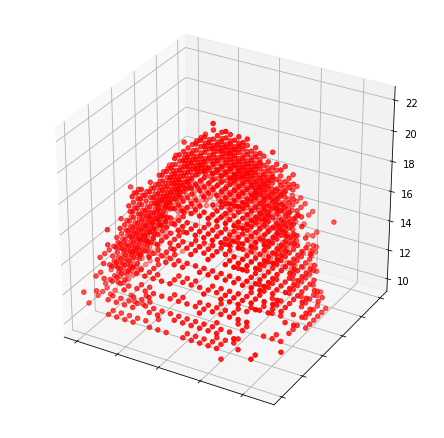

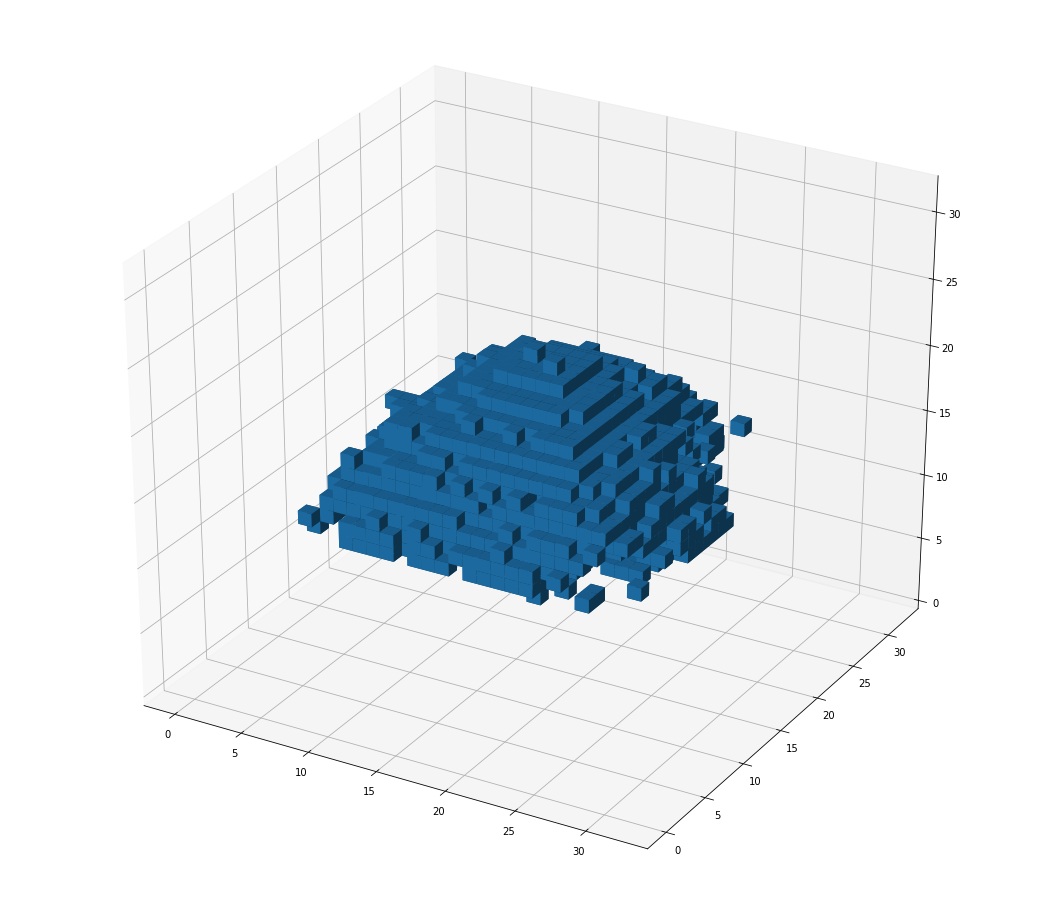

In [124]:
#I CAN FIND THE POSITIONS OF THE NON-ZERO ELEMENTS...CAN I USE THIS?

#get the values > number
voxels = image.__ge__(0.1)
fig = plt.figure(figsize=(32, 16))
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.05, hspace=0.05)

print(voxels.shape)
#print(voxels)
for i, sample in enumerate(voxels):
        #print(sample.shape)
        s = sample.nonzero()#.reshape([3,27000])
        #print(s)
        x,y,z = s
        
        ax = plt.subplot(gs[i], projection='3d')
        ax.scatter(x, y, z, zdir='z', c='red')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        fig = plt.figure()
        fig.set_size_inches(18.5, 16.5)
        ax = fig.gca(projection='3d')
        ax.voxels(voxels.squeeze())#, edgecolor='cyan')
        #ax.set_aspect('equal')
#plt.savefig(path + '{}.png'.format(str(iteration).zfill(3)), bbox_inches='tight')
#plt.close()


#print(test_vox[0].shape)
#v=test_vox[0].squeeze()#.reshape([3,8000])
#print(v.shape)
#ax.voxels(v)
#plt.show()

In [127]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import skimage
import skimage.measure

In [130]:
voxels.shape

(1, 32, 32, 32)

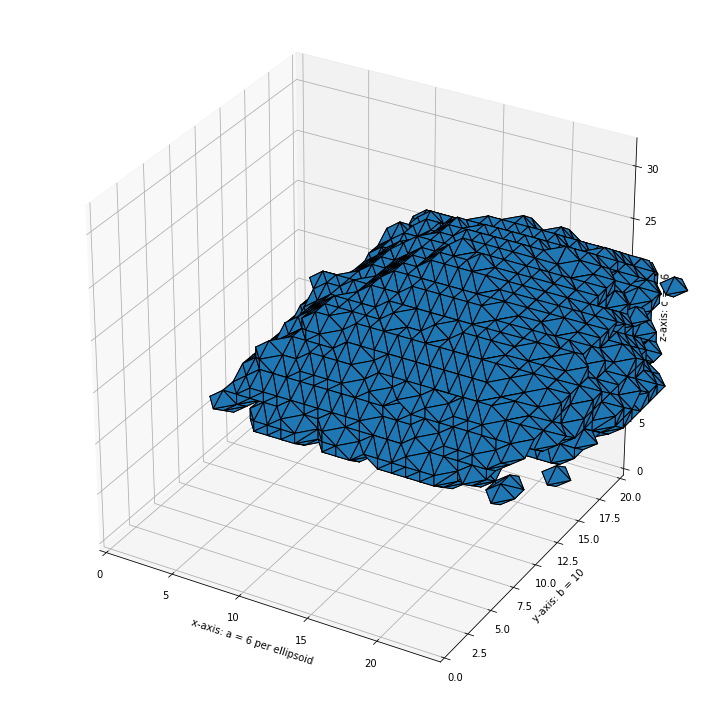

In [134]:
verts, faces, normals, values = skimage.measure.marching_cubes(voxels.squeeze(),0)
finMesh = trimesh.Trimesh(verts,faces)
finMesh = trimesh.smoothing.filter_humphrey(finMesh, alpha=0.1, beta=0.3, iterations=15, laplacian_operator=None)

fig = plt.figure(figsize=(10,10))

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])

mesh.set_edgecolor('k')
ax = fig.gca(projection='3d')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 24)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 20)  # b = 10
ax.set_zlim(0, 32)  # c = 16

plt.tight_layout()
plt.show()

In [135]:
finMesh.export('dMesh_s.obj')

'# https://github.com/mikedh/trimesh\nv 7.94173907 8.01073415 12.29387138\nv 7.98484039 7.60217699 16.65107097\nv 8.30833695 15.81027177 13.18296310\nv 7.63000837 15.95033472 12.26454738\nv 8.04463577 15.96489373 17.98703204\nv 8.17865314 23.95808947 12.95934613\nv 8.87784600 24.06255287 10.83157402\nv 7.81761858 23.79378291 16.75773596\nv 8.00078622 6.67443086 16.00271681\nv 7.63714181 7.05207166 12.11440418\nv 7.99046402 6.41624314 11.21760900\nv 8.10284409 15.00092732 12.74889874\nv 8.09022086 14.84405665 18.12282874\nv 7.79439284 23.20567371 13.62746727\nv 7.51337914 23.19489208 13.13020682\nv 8.00000000 22.04109589 11.00000000\nv 7.98219038 23.11581545 17.14548925\nv 7.90710191 5.82682408 15.07937289\nv 8.28092221 5.80013737 10.46761958\nv 7.93024019 14.19606361 12.40594668\nv 7.94413286 14.02982219 18.08234897\nv 8.17038751 21.85771544 16.41200157\nv 8.59906076 21.69303752 15.10737868\nv 7.84224262 22.22059372 13.22512591\nv 8.00000000 22.00000000 11.04109589\nv 8.00000000 22.000